## POS tagging using modified Viterbi

STEPS: 

1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
   - Divide the Treebank corpus into 95:5 ration for training and test set
   - Do exloratory data analysis on training and test data set.
      a. identify unique words in train data set(vocabulary)
      b. identify unique tag in train data set (tag set)
      c. identify unique words in test set.
      d. identify unique tags in test set.
      c. count of each tags in train set.
      d. count of each tags in test set.
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Develop plain venilla Viterbi Heuristic algorithm
4. Develop laplace Viterbi Heuristic algoritham, use some laplace value for emission_probability
5. Develop lexicon_unigram_rulebased viterbi algoritham , call lexican_unigram_rulebased algoritham if emission_probability for a word is zero.
6. Checking accuracy on the test data set on plain venilla viterbi
7. Checking accuracy on the test data set on laplace viterbi
8. Checking accuracy on the test data set on lexicon_unigram_rulebased viterbi
9. diplay the tag assigned by plain venilla viterbi , laplace viterbi and test_set tag
10. diplay the tag assigned by plain venilla viterbi , lexicon_unigram_rulebase viterbi and test_set tag


## 1. Exploring Treebank Tagged Corpus

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter

#### Read Treebank tagged dataset

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

## 1. Exploring Treebank Tagged Corpus

In [3]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

#### split the treebank data set into train and test set with 95:5 ratio

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,random_state=1,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('He', 'PRON'), ('has', 'VERB'), ('promised', 'VERB'), ('stiffer', 'ADJ'), ('fines', 'NOUN'), (',', '.'), ('though', 'ADP'), ('the', 'DET'), ('size', 'NOUN'), ('of', 'ADP'), ('penalties', 'NOUN'), ('sought', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('OSHA', 'NOUN'), ('have', 'VERB'), ('been', 'VERB'), ('rising', 'VERB'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('even', 'ADV'), ('before', 'ADP'), ('he', 'PRON'), ('took', 'VERB'), ('office', 'NOUN'), ('this', 'DET'), ('year', 'NOUN'), ('.', '.')], [('At', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('time', 'NOUN'), (',', '.'), ('though', 'ADV'), (',', '.'), ('he', 'PRON'), ('chastised', 'VERB'), ('the', 'DET'), ('media', 'NOUN'), ('for', 'ADP'), ('*', 'X'), ('paying', 'VERB'), ('such', 'ADJ'), ('close', 'ADJ'), ('attention', 'NOUN'), ('to', 'PRT'), ('Japanese', 'ADJ'), ('investment', 'NOUN'), ('when', 'ADV'), ('other', 'ADJ'), ('foreign', 'ADJ'), ('countries', 'NOUN'), (',', '.'), ('notably', 'ADV'), ('Britain', 'NOUN'),

### do Exploratory analysis on Train Set


#### Get the list of tagged words in train set

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95668

#### there are 95668 taged words in train set

In [6]:
# train tokens 
tokens = [pair[0] for pair in train_tagged_words]
print(len(tokens))


95668


#### There are 95668 wrods in train set


#### Vocabulary of words , unique set of words from train_tagged_words


In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12097


#### There are 12097 unique words in the train set

#### unique set of tags from train_tagged_words

In [8]:
# get unique tags from train_tagged_Words
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

#### There are 12 unique tags used in the train set

#### Count the number of tags on each tag (tag frequency)

In [9]:
tags = [pair[1] for pair in train_tagged_words]
tag_counts = Counter(tags)
print(tag_counts)

Counter({'NOUN': 27474, 'VERB': 12864, '.': 11154, 'ADP': 9339, 'DET': 8294, 'X': 6291, 'ADJ': 6064, 'NUM': 3359, 'PRT': 3070, 'ADV': 3003, 'PRON': 2608, 'CONJ': 2148})


In [10]:
print(tag_counts.most_common(5))

[('NOUN', 27474), ('VERB', 12864), ('.', 11154), ('ADP', 9339), ('DET', 8294)]


#### Most common tags are Noun and Verb

### do Exploratory analysis on Test Set 

#### Get the list of tagged words in Test set

In [11]:
# Getting list of tagged words
test_tagged_words = [tup for sent in test_set for tup in sent]
len(test_tagged_words)

5008

#### There are 5008 tagged words in the test set

In [12]:
# test tokens 
test_tokens = [pair[0] for pair in test_tagged_words]
print(len(test_tokens))

5008


#### There are 5008 wrods in test set

#### Vocabulary of words , unique set of words from test_tagged_words


In [13]:
# vocabulary in test set
V_test = set(test_tokens)
print(len(V_test))

1866


#### There are 1866 unique words in the train set

#### find words present in test set , but not present in train set

In [14]:
test_unknownWords = list()
V_test_list = list(V_test)
V_list = list(V)
for i in range(len(V_test_list)):
    term = V_test_list[i]
    if ( term in V_list):
        continue;
    else:
        test_unknownWords.append(term)
print(len(test_unknownWords))


311


#### There are 311 words that are present in Test Set and not present in Train set

In [15]:
print(test_unknownWords)

['dwindling', 'lung', '17.4', 'Compare', 'colder', 'pre-1917', 'boilers', 'pledged', 'pre-tax', 'caveat', 'trail', 'accidents', 'dams', 'ailing', 'reasserts', 'Manila', 'leveraging', 'Financing', 'beforehand', 'established', 'Campaign', 'altered', 'custom', 'savvier', 'Supportive', 'Zurich', 'Sweden', 'male-only', 'cumbersome', 'Youths', 'everybody', 'breakfast', 'pep', 'red-flag', 'Lurgi', 'impressive', 'blinks', 'leather', 'pressing', 'owning', '16.9', 'aspersions', 'Payments', 'steadily', '19.95', 'Nicaraguan', 'Bolivia', 'mindful', 'mail', 'broadened', '*T*-121', 'computer-generated', 'faint', 'Californian', '*T*-97', 'mesothelioma', 'G.m.b', 'Midland', 'Intecknings', 'cleanup', 'long-time', '190-point', 'track', 'cheerleaders', '7.79', 'occupying', '50\\/50', '*-145', 'impeding', '12.82', 'Kawasaki', 'Yasuda', 'farms', 'Cultural', 'clerics', 'resumes', 'Otherwise', '570', '*T*-101', '114', '300-day', 'achievement-test', 'rancor', 'decried', '16.09', 'guaranteed', 'precise', 'unfet

#### unique set of tags from test_tagged_words

In [16]:
# get unique tags from test_tagged_Words
# number of tags
T_test = set([pair[1] for pair in test_tagged_words])
len(T_test)

12

#### There are 12 unique tags used in the train set

#### Count the number of tags on each tag (tag frequency) in test set

In [17]:
tags_Test = [pair[1] for pair in test_tagged_words]
tag_counts_test = Counter(tags_Test)
print(tag_counts_test)

Counter({'NOUN': 1393, 'VERB': 700, '.': 561, 'ADP': 518, 'DET': 431, 'ADJ': 333, 'X': 322, 'NUM': 187, 'ADV': 168, 'PRT': 149, 'PRON': 129, 'CONJ': 117})


In [18]:
print(tag_counts_test.most_common(3))

[('NOUN', 1393), ('VERB', 700), ('.', 561)]


#### NOUN and VERB are most common tags in Test test also

#### print unique tags from train_tagged_words

In [19]:
print(T)

{'CONJ', '.', 'X', 'ADJ', 'ADV', 'PRON', 'ADP', 'PRT', 'DET', 'NUM', 'NOUN', 'VERB'}


In [20]:
# V : vocubulary of words in train_tagged_words
# T: unique tags in train_tagged_words

t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

print(t)
print(v)

12
12097


## 2. POS Tagging Algorithm - HMM
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

In [21]:
# V : vocubulary of words in train_tagged_words
# T: unique tags in train_tagged_words

t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

#### define a dictionary , which stores emission probability for a given word and tag, key = 'word' + 'tag'

In [22]:
emissProbDict = dict()


###  function for calculating Emission Probabilities

In [23]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### function for calculating Transition Probabilities

In [24]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [25]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [26]:
tags_matrix

array([[4.6554935e-04, 3.5381749e-02, 8.8454373e-03, 1.2197393e-01,
        5.4469272e-02, 5.9590317e-02, 4.9813781e-02, 4.1899444e-03,
        1.2057728e-01, 4.0502794e-02, 3.4962755e-01, 1.5456238e-01],
       [5.8185406e-02, 9.2253901e-02, 2.7703065e-02, 4.3930430e-02,
        5.2537207e-02, 6.5805987e-02, 9.2433207e-02, 2.0620406e-03,
        1.7213556e-01, 8.1764393e-02, 2.2234176e-01, 8.8757396e-02],
       [1.0491177e-02, 1.6372596e-01, 7.4868858e-02, 1.6531553e-02,
        2.5433159e-02, 5.5158161e-02, 1.4353839e-01, 1.8534414e-01,
        5.5317119e-02, 2.7022732e-03, 6.2947065e-02, 2.0394213e-01],
       [1.6985489e-02, 6.4478889e-02, 2.1108180e-02, 6.7282319e-02,
        4.7823219e-03, 6.5963063e-04, 7.6022424e-02, 1.0883905e-02,
        4.9472298e-03, 2.1273088e-02, 7.0003301e-01, 1.1543536e-02],
       [6.3270065e-03, 1.3852814e-01, 2.2977022e-02, 1.2853813e-01,
        7.8921080e-02, 1.5318016e-02, 1.1655012e-01, 1.3986014e-02,
        6.8931065e-02, 3.1635031e-02, 3.1635

In [27]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [28]:
tags_df

,CONJ,.,X,ADJ,ADV,PRON,ADP,PRT,DET,NUM,NOUN,VERB
CONJ,0.000466,0.035382,0.008845,0.121974,0.054469,0.059590,0.049814,0.004190,0.120577,0.040503,0.349628,0.154562
.,0.058185,0.092254,0.027703,0.043930,0.052537,0.065806,0.092433,0.002062,0.172136,0.081764,0.222342,0.088757
X,0.010491,0.163726,0.074869,0.016532,0.025433,0.055158,0.143538,0.185344,0.055317,0.002702,0.062947,0.203942
ADJ,0.016985,0.064479,0.021108,0.067282,0.004782,0.000660,0.076022,0.010884,0.004947,0.021273,0.700033,0.011544
ADV,0.006327,0.138528,0.022977,0.128538,0.078921,0.015318,0.116550,0.013986,0.068931,0.031635,0.031635,0.346653
PRON,0.004985,0.040261,0.093942,0.072853,0.035276,0.006902,0.023006,0.013037,0.009586,0.007285,0.212040,0.480828
ADP,0.000857,0.040261,0.033837,0.105793,0.013813,0.069172,0.017025,0.001285,0.323803,0.061141,0.324660,0.008352
PRT,0.002280,0.043648,0.014007,0.085993,0.010098,0.018241,0.019544,0.001954,0.101629,0.056026,0.246254,0.400326
DET,0.000482,0.018085,0.045696,0.204847,0.012539,0.003497,0.009163,0.000241,0.005305,0.022305,0.638896,0.038944
NUM,0.013397,0.118190,0.214350,0.033343,0.002977,0.001191,0.033641,0.027687,0.003275,0.184876,0.350402,0.016672


In [29]:
tags_df.loc['.', :]

CONJ    0.058185
.       0.092254
X       0.027703
ADJ     0.043930
ADV     0.052537
PRON    0.065806
ADP     0.092433
PRT     0.002062
DET     0.172136
NUM     0.081764
NOUN    0.222342
VERB    0.088757
Name: ., dtype: float32

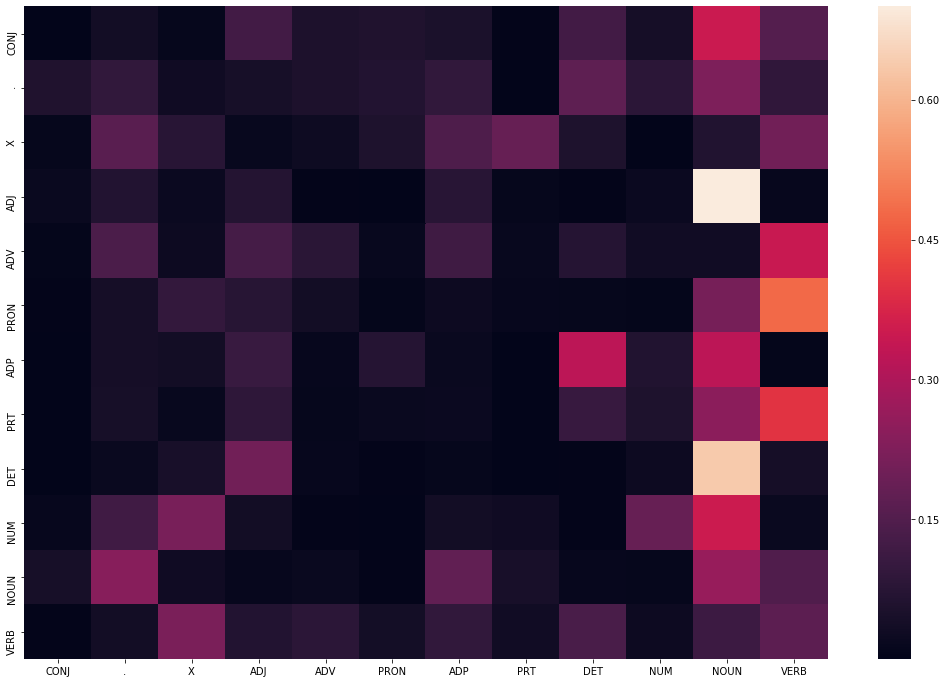

In [30]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

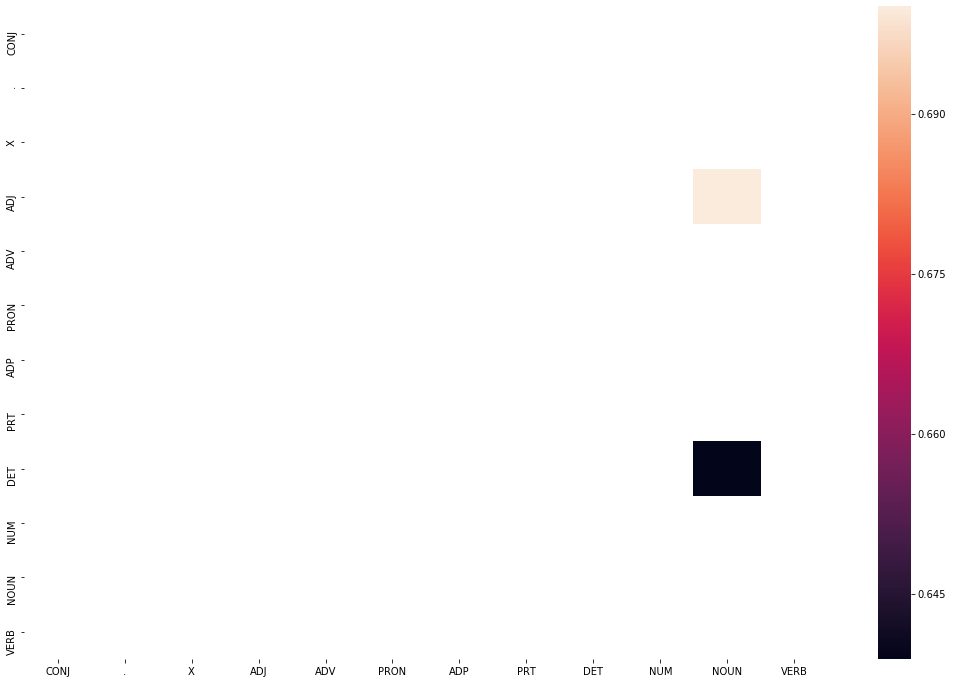

In [31]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## Build the Plain vanilla Viterbi based POS tagger

In [32]:
unknowWordsList_plainVenilla = list() 

#### define a funciton which calculates the emission propability  , which is an optimized method

In [33]:
def emissionProb(word,tag):
    # form a key = word + tag
    dictWord = word + tag
    #  optisation method: method first search in emissionprobability dictionay , if the key(compination of word + tag)
    # is present , if it present then use the value as empission probability , else calculate 
    # the emission probability
    # by calling word_given_tagand store in emissionprobability dictionay
    if (dictWord in emissProbDict.keys()):
        emission_p =   emissProbDict[dictWord]
    else:
        wordTagCount = word_given_tag(word, tag)
        emission_p = wordTagCount[0]/wordTagCount[1]
        emissProbDict[dictWord] = emission_p
    return emission_p

In [34]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = emissionProb(words[key],tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        # get all unknown words in to seperate list
        if(pmax == 0):
            unknowWordsList_plainVenilla.append(words[key])
            
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

## 4. Evaluating on Test Set

In [35]:
# list of sents
test_run = [test_set[i] for i in range(len(test_set))]
#test_run = [test_set[i] for i in range(30)]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]


#### run  plain vellina Viterbi on test_set

In [36]:
# tagging the test sentences
start = time.time()
tagged_seq_plain_verterbi = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [37]:
print("Time taken in seconds by plain venilla viterbi tagger ", difference)



Time taken in seconds by plain venilla viterbi tagger  181.44806241989136


#### find the unmatched tag with the test set from the predicted one using plain vellina verterbi

In [38]:
matched_plain_veterbi_found_list = []
unmatched_plain_veterbi_found_list = []

for i in range(len(tagged_seq_plain_verterbi)):
    tup = tagged_seq_plain_verterbi[i]
    if (tup in test_run_base):
        matched_plain_veterbi_found_list.append(tup)
    else:
        unmatched_plain_veterbi_found_list.append(tup)

#### Calculate accuracy for plain_veterbi for test set

In [39]:
check = [i for i, j in zip(tagged_seq_plain_verterbi, test_run_base) if i == j] 
accuracy_plain_verterbi = len(check)/len(tagged_seq_plain_verterbi)

In [40]:
print("Plain vellina veterbi accuracy = ",accuracy_plain_verterbi)

Plain vellina veterbi accuracy =  0.9073482428115016


#### list  the correct test taged words along with predicted tagged word, which is predicted by plain vellina viterbi

In [41]:
wrong_tagged_plain_viterbi = []
for i in range(len(test_run_base)):
    tup1 = tagged_seq_plain_verterbi[i]
    tup2 = test_run_base[i]
    
    if((tup1[0] == tup2[0]) and ( tup1[1] != tup2[1])):
        l2 = []
        #print(tup1,tup2)
        l2.append(tup1)
        l2.append(tup2)
        wrong_tagged_plain_viterbi.append(l2)


### Solve the problem of unknown words

### 1. considering very small Emission probability for unknown words (laplace Technique)

#### modify plain velina verterbi funciton , by adding small laplace value to emission probability

In [42]:
# Viterbi Heuristic , by considering small value of laplace value  for emission probability
def Viterbi_laplace(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     # add small laplace value for emission_probailiby
    laplace_value = 1/10000000
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p =  laplace_value + emissionProb(words[key],tag)
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

#### Tagging using Viterbi_laplace for test_set

In [43]:
# tagging the test sentences
start = time.time()
tagged_seq_verterbi_laplace = Viterbi_laplace(test_tagged_words)
end = time.time()
difference = end-start

In [44]:
print("Time taken in seconds for laplace viterbi tagger: ", difference)

Time taken in seconds for laplace viterbi tagger:  0.9275214672088623


#### calculate accuracy for lapace verterbi method on test set

In [45]:
# accuracy
check = [i for i, j in zip(tagged_seq_verterbi_laplace, test_run_base) if i == j] 
accuracy_laplace = len(check)/len(tagged_seq_verterbi_laplace)

In [46]:
print("Plain laplace veterbi accuracy = ",accuracy_laplace)

Plain laplace veterbi accuracy =  0.9363019169329073


#### find the unmatched tag with the test set from the predicted one


In [47]:
matched_laplace_veterbi_found_list = []
unmatched_laplace_veterbi_ound_list = []

for i in range(len(tagged_seq_verterbi_laplace)):
    tup = tagged_seq_verterbi_laplace[i]
    if (tup in test_run_base):
        matched_laplace_veterbi_found_list.append(tup)
    else:
        unmatched_laplace_veterbi_ound_list.append(tup)

#### list  the correct test taged words along with predicted tagged word, which is predicted by laplace_veterbi

In [48]:
wrong_tagged_laplace_viterbi = []
for i in range(len(test_run_base)):
    tup1 = tagged_seq_verterbi_laplace[i]
    tup2 = test_run_base[i]
    
    if((tup1[0] == tup2[0]) and ( tup1[1] != tup2[1])):
        l2 = []
        #print(tup1,tup2)
        l2.append(tup1)
        l2.append(tup2)
        wrong_tagged_laplace_viterbi.append(l2)

## 2. considering Lexicon unigram and rule based tagging

In [49]:
from nltk.tag import UnigramTagger 
from nltk.tag import BigramTagger

#### define the pattern for rule_based_tagger

In [50]:
# example from the NLTK book
patterns = [
    (r'(The|the|A|a|An|an|That|that)$', 'DET'),
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'VERB'),              # modals
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^\*-(.[0-9]+)?$', 'X'),
    (r'^\*T\*-(.[0-9]+)?$', 'X'),
    (r'^([a-zA-Z]+)-([a-zA-Z]+)?$', 'ADJ'),
    (r'.*', 'NOUN')                    # nouns
]

#### define rule based tagger

In [51]:

rule_based_tagger = nltk.RegexpTagger(patterns)

#### define bigram Tagger with backoff = rule_based_tagger

In [52]:
unigram_tagger = UnigramTagger(train_set, backoff=rule_based_tagger) 
bigram_tagger = BigramTagger(train_set,backoff=unigram_tagger)

#### define a function for unigram tagging

In [53]:
def lexicon_uniGram(word):
    l1 = unigram_tagger.tag(word)
    #l1 = bigram_tagger.tag(word)  # with bigram_tagger , our accuracy is reduced to 92% 
                                   #so i am using unigram_tagger
    return l1


####  modify plain velina veterbi for calling lexicon unigram  tagging funciton, when emission probability is zero

In [54]:
# use lexicon unigram tagging when  emission probability is zero
def Viterbi_lex_unigram(words, train_bag = train_tagged_words):
  
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    key = 0
   
    for word in (words):
        #initialise list of probability column for a given observation
        p = [] 
        lexicon_tag = False;
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p =  emissionProb(words[key],tag)
            keyset = [];
            keyset.append(words[key])
            if (emission_p == 0):
                lexicon_tag = True
                l1 = lexicon_uniGram(keyset)
                break;
            else:
                state_probability = emission_p * transition_p    
                p.append(state_probability)
        if (lexicon_tag):
            tup = l1[0]
            tag1 = tup[1]
            state.append(tag1)
        else:
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        key = key + 1
        
    return list(zip(words, state))

#### Tagging using Viterbi_lexicon_bigram on test_set

In [55]:
# tagging the test sentences
start = time.time()
tagged_seq_lexicon = Viterbi_lex_unigram(test_tagged_words)
end = time.time()
difference = end-start

In [56]:
print("Time taken in seconds for lexicon_unigram_rulebased tagger : ", difference)

Time taken in seconds for lexicon_unigram_rulebased tagger :  0.11070656776428223


#### calculate accuracy for lapace verterbi method on test set

In [57]:
# accuracy
check = [i for i, j in zip(tagged_seq_lexicon, test_run_base) if i == j] 
accuracy_lexicon = len(check)/len(tagged_seq_lexicon)

In [58]:
print("Plain laplace viterbi accuracy = ",accuracy_lexicon)

Plain laplace viterbi accuracy =  0.9476837060702875


#### find the unmatched tag with the test set from the predicted one

In [59]:
matched_lexicon_veterbi_found_list = []
unmatched_lexicon_veterbi_found_list = []


for i in range(len(tagged_seq_lexicon)):
    tup = tagged_seq_lexicon[i]
    if (tup in test_run_base):
        matched_lexicon_veterbi_found_list.append(tup)
    else:
        unmatched_lexicon_veterbi_found_list.append(tup)

#### list correct test taged words along with predicted tagged word, which is predicted by Viterbi_lex_unigram

In [60]:
wrong_tagged_lexicon_viterbi = []
for i in range(len(test_run_base)):
    tup1 = tagged_seq_lexicon[i]
    tup2 = test_run_base[i]
    
    if((tup1[0] == tup2[0]) and ( tup1[1] != tup2[1])):
        l2 = []
        #print(tup1,tup2)
        l2.append(tup1)
        l2.append(tup2)
        wrong_tagged_lexicon_viterbi.append(l2)

#### Evaluating tagging accuracy

#### Plain vellina veterbi accuracy

In [61]:
check1 = [i for i, j in zip(tagged_seq_plain_verterbi, test_run_base) if i == j] 
accuracy_plain_verterbi = len(check1)/len(tagged_seq_plain_verterbi)

#### Laplace verterbi accuracy

In [62]:
# accuracy
check = [i for i, j in zip(tagged_seq_verterbi_laplace, test_run_base) if i == j] 
accuracy_laplace = len(check)/len(tagged_seq_verterbi_laplace)

#### Lexicon unigram with back-off rule bassed tagger accuracy

In [63]:
# accuracy
check = [i for i, j in zip(tagged_seq_lexicon, test_run_base) if i == j] 
accuracy_lexicon = len(check)/len(tagged_seq_lexicon)

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [64]:
print("Plain venilla viterbi accuracy = ", accuracy_plain_verterbi)

Plain venilla viterbi accuracy =  0.9073482428115016


In [65]:
print(" laplace viterbi accuracy = ", accuracy_laplace)

 laplace viterbi accuracy =  0.9363019169329073


In [66]:
print(" lexicon_rule_based viterbi accuracy = ", accuracy_lexicon)

 lexicon_rule_based viterbi accuracy =  0.9476837060702875


## List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications¶

### 1. let us find diffent tag assigend by venilla viterbi and laplace veterbi Methods.

In [67]:
wrong_tagged_venilla_laplace = list()
wrong_word_laplace = list()
for i in range(len(test_run_base)):
    tup_venilla = tagged_seq_plain_verterbi[i]
    tup_laplace = tagged_seq_verterbi_laplace[i]
    tup_test = test_run_base[i]
    
    if((tup_test[0] == tup_venilla[0]) and ( tup_test[1] != tup_venilla[1])):
        if ( (tup_venilla[0] == tup_laplace[0]) and (tup_venilla[1] != tup_laplace[1] )):
            l2 = []        
            l2.append(tup_venilla)
            l2.append(tup_laplace)
            l2.append(tup_test)
            wrong_tagged_venilla_laplace.append(l2)
            wrong_word_laplace.append(tup_test[0])
        

In [68]:
for item in wrong_tagged_venilla_laplace:
    tup_venilla = item[0]
    tup_laplace = item[1]
    tup_test = item[2]
    print("venilla vitervi tag = %s , laplace viterbi tag = %s , test_set tag = %s"%(tup_venilla,tup_laplace,tup_test))

venilla vitervi tag = ('cleanup', 'CONJ') , laplace viterbi tag = ('cleanup', 'NOUN') , test_set tag = ('cleanup', 'NOUN')
venilla vitervi tag = ('burn', 'CONJ') , laplace viterbi tag = ('burn', 'NOUN') , test_set tag = ('burn', 'VERB')
venilla vitervi tag = ('cleaner-burning', 'CONJ') , laplace viterbi tag = ('cleaner-burning', 'NOUN') , test_set tag = ('cleaner-burning', 'ADJ')
venilla vitervi tag = ('fuels', 'CONJ') , laplace viterbi tag = ('fuels', 'NOUN') , test_set tag = ('fuels', 'NOUN')
venilla vitervi tag = ('*-94', 'CONJ') , laplace viterbi tag = ('*-94', 'X') , test_set tag = ('*-94', 'X')
venilla vitervi tag = ('*T*-117', 'CONJ') , laplace viterbi tag = ('*T*-117', 'NOUN') , test_set tag = ('*T*-117', 'X')
venilla vitervi tag = ('Jennison', 'CONJ') , laplace viterbi tag = ('Jennison', 'NOUN') , test_set tag = ('Jennison', 'NOUN')
venilla vitervi tag = ('bell-ringing', 'CONJ') , laplace viterbi tag = ('bell-ringing', 'NOUN') , test_set tag = ('bell-ringing', 'ADJ')
venilla v

#### Display the differece in tag between venilla viterbi and laplase veterbi using dataframe

In [69]:

tags_matrix_laplase = np.empty((len(wrong_word_laplace), 3), dtype='object')
for i in range(len(wrong_word_laplace)):
    item = wrong_tagged_venilla_laplace[i]
    for j in range(3): 
        tag = item[j]
        tag1 = tag[1]
        tags_matrix_laplase[i, j] = tag1
col = ['Plain venilla-Virterbi tag' , 'Laplace-Virterbi tag', 'Test-set tag']
tags_df_laplace = pd.DataFrame(tags_matrix_laplase, columns = col, index=wrong_word_laplace)
tags_df_laplace


,Plain venilla-Virterbi tag,Laplace-Virterbi tag,Test-set tag
cleanup,CONJ,NOUN,NOUN
burn,CONJ,NOUN,VERB
cleaner-burning,CONJ,NOUN,ADJ
fuels,CONJ,NOUN,NOUN
*-94,CONJ,X,X
*T*-117,CONJ,NOUN,X
Jennison,CONJ,NOUN,NOUN
bell-ringing,CONJ,NOUN,ADJ
Ancient,CONJ,NOUN,NOUN
Youths,CONJ,NOUN,NOUN


### 2. let us find diffent tag assigend by venilla viterbi and  lexicon rule based Methods..

In [70]:

wrong_tagged_veniall_lexicon = list()
wrong_word_lexicon = list()
for i in range(len(test_run_base)):
    tup_venilla = tagged_seq_plain_verterbi[i]
    tup_lex = tagged_seq_lexicon[i]
    tup_test = test_run_base[i]
    
    if((tup_test[0] == tup_venilla[0]) and ( tup_test[1] != tup_venilla[1])):
        if ( (tup_venilla[0] == tup_lex[0]) and (tup_venilla[1] != tup_lex[1] )):
            l2 = []        
            l2.append(tup_venilla)
            l2.append(tup_lex)
            l2.append(tup_test)
            wrong_tagged_veniall_lexicon.append(l2)
            wrong_word_lexicon.append(tup_test[0])


In [71]:
for item in wrong_tagged_veniall_lexicon:
    tup_venilla = item[0]
    tup_lex = item[1]
    tup_test = item[2]
    print("venilla vitervi tag = %s , lexicon tag = %s , test_set tag = %s"%(tup_venilla,tup_lex,tup_test))

venilla vitervi tag = ('cleanup', 'CONJ') , lexicon tag = ('cleanup', 'NOUN') , test_set tag = ('cleanup', 'NOUN')
venilla vitervi tag = ('burn', 'CONJ') , lexicon tag = ('burn', 'NOUN') , test_set tag = ('burn', 'VERB')
venilla vitervi tag = ('cleaner-burning', 'CONJ') , lexicon tag = ('cleaner-burning', 'VERB') , test_set tag = ('cleaner-burning', 'ADJ')
venilla vitervi tag = ('fuels', 'CONJ') , lexicon tag = ('fuels', 'NOUN') , test_set tag = ('fuels', 'NOUN')
venilla vitervi tag = ('*-94', 'CONJ') , lexicon tag = ('*-94', 'X') , test_set tag = ('*-94', 'X')
venilla vitervi tag = ('*T*-117', 'CONJ') , lexicon tag = ('*T*-117', 'X') , test_set tag = ('*T*-117', 'X')
venilla vitervi tag = ('Jennison', 'CONJ') , lexicon tag = ('Jennison', 'NOUN') , test_set tag = ('Jennison', 'NOUN')
venilla vitervi tag = ('bell-ringing', 'CONJ') , lexicon tag = ('bell-ringing', 'VERB') , test_set tag = ('bell-ringing', 'ADJ')
venilla vitervi tag = ('Ancient', 'CONJ') , lexicon tag = ('Ancient', 'NOUN'

#### Display the differece in tag between venilla viterbi and Lexicon veterbi using dataframe

In [72]:
tags_matrix_lexicon = np.empty((len(wrong_word_lexicon), 3), dtype='object')
for i in range(len(wrong_word_lexicon)):
    item = wrong_tagged_veniall_lexicon[i]
    for j in range(3): 
        tag = item[j]
        tag1 = tag[1]
        tags_matrix_lexicon[i, j] = tag1
col = ['Plain-Venilla-Virterbi tag' , 'Lexicon-Virterbi tag', 'Test-set tag']
tags_df_lexicon = pd.DataFrame(tags_matrix_lexicon, columns = col, index=wrong_word_lexicon)
tags_df_lexicon


,Plain-Venilla-Virterbi tag,Lexicon-Virterbi tag,Test-set tag
cleanup,CONJ,NOUN,NOUN
burn,CONJ,NOUN,VERB
cleaner-burning,CONJ,VERB,ADJ
fuels,CONJ,NOUN,NOUN
*-94,CONJ,X,X
*T*-117,CONJ,X,X
Jennison,CONJ,NOUN,NOUN
bell-ringing,CONJ,VERB,ADJ
Ancient,CONJ,NOUN,NOUN
Youths,CONJ,NOUN,NOUN


### Run all the three viterbi algorithon on test_sentences.txt file words

#### read the file test_sentence.txt

In [73]:
test_words=list()
fhandle = open("Test_sentences.txt", "r")
for line in fhandle:
    words = line.split()
    for word in words:
        test_words.append(word.strip())


#### call plain venilla viterbi on test sentences

In [74]:
start = time.time()
tagged_seq_plain_viterbi_test= Viterbi(test_words)
end = time.time()
difference = end-start

In [75]:
print("time taken to execute plain viterbi = ",difference)

time taken to execute plain viterbi =  7.345329523086548


#### call laplace viterbi on test sentences

In [76]:
start = time.time()
tagged_seq_laplace_viterbi_test= Viterbi_laplace(test_words)
end = time.time()
difference = end-start

In [77]:
print("time taken to execute laplace viterbi = ",difference)

time taken to execute laplace viterbi =  0.04006552696228027


In [78]:
start = time.time()
tagged_seq_lexicon_viterbi_test= Viterbi_lex_unigram(test_words)
end = time.time()
difference = end-start

In [79]:
print("time taken to execute lexicon viterbi = ",difference)

time taken to execute lexicon viterbi =  0.012966156005859375


### display tags assigned by venilla plain viterbi , laplace viterbi and lexicon viterbi

In [80]:
tags_matrix_w = np.empty((len(test_words), 3), dtype='object')
for i in range(len(test_words)):
    tag1 = tagged_seq_plain_viterbi_test[i]
    tag2 = tagged_seq_laplace_viterbi_test[i]
    tag3 = tagged_seq_lexicon_viterbi_test[i]
    tags_matrix_w[i,0] = tag1[1]
    tags_matrix_w[i,1] = tag2[1]
    tags_matrix_w[i,2] = tag3[1]

In [81]:
col = ['Plain-Venilla-Viterbi tag' , 'laplase-Viterbi tag', 'Lexicon_viterbi tag']
tags_df_test = pd.DataFrame(tags_matrix_w, columns = col, index=test_words)
tags_df_test

,Plain-Venilla-Viterbi tag,laplase-Viterbi tag,Lexicon_viterbi tag
Android,CONJ,NOUN,NOUN
is,VERB,VERB,VERB
a,DET,DET,DET
mobile,ADJ,ADJ,ADJ
operating,NOUN,NOUN,NOUN
system,NOUN,NOUN,NOUN
developed,VERB,VERB,VERB
by,ADP,ADP,ADP
Google.,CONJ,NOUN,NOUN
Android,CONJ,NOUN,NOUN
